## Imports.

In [30]:
## Imports.
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

sns.set() #set Seaborn theme on plots.

from datetime import date
from transformers.models.bert import BertForMaskedLM
from transformers.models.roberta import RobertaForMaskedLM, RobertaTokenizerFast
from transformers import AutoTokenizer, BertTokenizer
from transformers import FillMaskPipeline

/home/hjvm/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-03 23:21:29.822709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 23:21:30.350250: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 23:21:30.441689: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to 

## Constants & Directories.

In [43]:
## Hyperparameters.
USE_GPU = True

## Models.

# BabyBERTa.
# The authors made 3/10 random initializations of the model publicly available.
MODELS = ['phueb/BabyBERTa-1', 
          'phueb/BabyBERTa-2', 
          'phueb/BabyBERTa-3', 
          'bert-base-cased', 
          'bert-large-cased', 
          'roberta-base',
          'roberta-large',
        ] 
SAVED_MODELS = ['saved_models/BabyBERTa_AO-CHILDES',
                'saved_models/BabyBERTa_AO-CHILDES_standard_masking',
                'saved_models/BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1',
                'saved_models/BabyBERTa_AO-Newsela',
                'saved_models/BabyBERTa_Wikipedia-1',
               ]

## Data.

# CHILDES.
CHILDES = './data/CHILDES/aochildes.txt'

# BLiMP.
BLIMP = './data/BLiMP/' # data across many files.

# Zorro.
ZORRO = './data/Zorro/'
ZORRO_SCRAMBLED = './data/Zorro_scrambled/'

## Output Directories.
BABYBERTA_CHILDES_OUT = './output/CHILDES/babyberta_childes_mlm.csv'
BABYBERTA_BLIMP_OUT = './output/BLiMP/babyberta_blimp_mlm.csv'
BABYBERTA_SCRAMBLED_ZORRO_OUT = './output/Zorro_scrambled/babyberta_zorro_scrambled_mlm.csv'

ALL_MODELS_BLIMP_OUT = './output/BLiMP/all_models_blimp_mlm.csv'
ALL_MODELS_ZORRO_OUT = './output/Zorro/all_models_zorro_mlm.csv'

## Torch Setup

In [32]:
## Set up Torch to use the GPU if available.
if USE_GPU and torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Will use the GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [214]:
model = RobertaForMaskedLM.from_pretrained(MODELS[0])
tokenizer = RobertaTokenizerFast.from_pretrained(MODELS[0],
                                          add_prefix_space=True,  # this must be added to produce intended behavior
                                          )
results = pseudo_log_prob("Does the rabbit speak?", model, tokenizer, include_unigram=False, device="cpu")
display(results)

{'sentence': 'Does the rabbit speak?', 'pseudoLogProb': -30.354648172855377}

## Helper Functions

In [33]:
## Helper function to apply Masked Language Modeling to an entire sentence (pseudo log probability).
def pseudo_log_prob(sentence, model, tokenizer, include_unigram=True, device="cpu"):
    '''
    Helper function to apply Masked Language Modeling to an entire sentence (pseudo log probability).
    This method applies the [MASK] token sequentially across each subword token of the sentence and
    queries the model for the log-likelihood of the original token.  The log likelihoods are summed
    across the entire sentence.  See Salazar et al. 2019 for comments.
    '''    
    logp_sentence = torch.tensor([0], dtype=torch.float64, device=device)
    unigram_prob = []
    # Get the full sentence embedding for MLM prediction.
    sent_tokenized = tokenizer(sentence, return_tensors="pt").to(device)
    for i in range(1, len(sent_tokenized["input_ids"][0])-1): # In order to skip the <start> and <end> tokens (vary by model).
        # Grab the original token before masking.               
        input_id = sent_tokenized["input_ids"][0, i].clone() # Need to copy the token_id tensor.
        #print("Original input id", input_id)
        
        # Apply the <mask> token in order.
        sent_tokenized["input_ids"][0, i] = tokenizer.mask_token_id
        #print("Input sentence:", tokenizer.convert_ids_to_tokens(sent_tokenized["input_ids"][0]))
                        
        # Get model outputs with softmax applied.  
        # Note: outputs will have shape batch_size x sequence_length x vocab_size.
        with torch.no_grad():
            outputs = model(**sent_tokenized, return_dict=True).logits.softmax(dim=2)
        #print(outputs)
        token_prob = outputs[0, i, input_id]#.detach().numpy()

        # Remove the <mask> token from the input for the next iteration.
        sent_tokenized["input_ids"][0, i] = input_id
        
        # Aggregate.
        logp_sentence += torch.log(token_prob)
        
        if not include_unigram: continue
        token = tokenizer.convert_ids_to_tokens([input_id])[0]
        unigram_prob.append({token:token_prob})
        
        #print(f"Probability of token {token}: {token_prob}")
    
    # This return will create new columns in the original dataframe.
    #return pd.Series([logp_sentence, unigram_prob], index=["mlm_logprob", "unigram_mlm_logprob"])
    
    # Unpack the pyTorch tensor.
    logp_sentence = logp_sentence.to("cpu").detach().numpy()[0]
    output = {'sentence':sentence, 
            'pseudoLogProb':logp_sentence}
    if include_unigram:
        output['mlmUnigramProb'] = unigram_prob
    
    return output

In [34]:
## Helper function to apply pseudo_log_prob to an entire DataFrame.
def batch_pll(model_name, sentence_df, sent_col, include_unigram=False, device="cpu"):
    '''
    Helper function to apply pseudo_log_prob to an entire DataFrame.  It works by vectorizing
    pseudo_log_prob() and applying it to the pandas column of interest indicated by the
    sent_col parameter.
    '''
    # Instantiate model with tokenizer.
    if "BabyBERTa" in model_name:
        model = RobertaForMaskedLM.from_pretrained(model_name)
        tokenizer = RobertaTokenizerFast.from_pretrained(model_name,
                                          add_prefix_space=True,  # this must be added to produce intended behavior
                                          )
    elif "roberta" in model_name:
        model = RobertaForMaskedLM.from_pretrained(model_name)
        tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
    elif "bert" in model_name:
        model = BertForMaskedLM.from_pretrained(model_name)
        tokenizer = BertTokenizer.from_pretrained(model_name)
    else:
        print("No valid model found!  Terminating execution...")
        return
    
    # Send the model to the GPU if chosen.
    model.to(device)
    
    ## Get MLM probability for each sentence in the sentences DataFrame.
    results = np.vectorize(pseudo_log_prob)(sentence_df[sent_col], model, tokenizer, include_unigram=include_unigram, device=device)
    results = pd.DataFrame(results.tolist())
    
    # Cleanup.
    del model
    del tokenizer    
    torch.cuda.empty_cache()
    
    return results

In [35]:
# Helper function to run all the models through a test set in minimal pair (BLiMP) format.
def test_models(model_names, test_set, 
                good_sent_col="sentence_good",
                bad_sent_col="sentence_bad", 
                output_dir=None,
                device="cpu"):
    
    if output_dir is not None and os.path.isfile(output_dir):
        all_models = pd.read_csv(output_dir)
    else:
        all_models = pd.DataFrame(columns=(list(test_set.columns) + ["model", "orig_min_pair_idx", "date"]))

    for model in model_names:
        print(f"Now testing {model}...")
        
        model_good = batch_pll(model, test_set, good_sent_col, device=device)
        model_bad = batch_pll(model, test_set, bad_sent_col, device=device)

        # Error checking.
        if model_good is None or model_bad is None:
            print(f"ERROR! Skipping... {model}")

        # Stitch together the two dataframes.
        model_test = test_set.merge(model_good["pseudoLogProb"], 
                                    left_index=True, 
                                    right_index=True, 
                                    copy=False, 
                                    validate="one_to_one")
        model_test = model_test.merge(model_bad["pseudoLogProb"],
                                      suffixes=("_good", "_bad"),    # Should produce something like "pseudoLogProb_good", "pseudoLogProb_bad"...
                                      left_index=True, 
                                      right_index=True, 
                                      copy=False, 
                                      validate="one_to_one")

        # Get model name.
        sep = model.rfind("/") # some model names may be paths.
        model_name = model[sep + 1:] # if "/" is not a path, rfind() returns -1 so the index is just [0:]...
        
        # Tag which model produced this data.
        model_test["model"] = model_name

        # Preserve the original index.
        model_test.index.rename("orig_min_pair_idx", inplace=True)
        model_test.reset_index(inplace=True)

        # Timestamp.
        model_test["date"] = date.today()

        # Stack the dataframes.
        all_models = pd.concat([all_models, model_test], ignore_index=True)

        # Export in case something goes wrong...
        if output_dir is not None:
            all_models.to_csv(output_dir, index=False)
    
    return all_models

In [36]:
def results_by_phenomenon(output_df, model_col="model", phenomenon_col="linguistics_term", correct_col="correct"):
    # Create new dataframe.
    results = pd.DataFrame(index=output_df[model_col].unique(), columns=output_df[phenomenon_col].unique())
    
    for idx, row in results.iterrows():
        subset = output_df.loc[output_df[model_col] == idx]
        for phenomenon in row.index:
            row[phenomenon] = subset[correct_col].loc[subset[phenomenon_col] == phenomenon].mean()
            
    return results

## Preprocessing & Data Loading.
I want each of the datasets in its own DataFrame.  This may be especially tricky for the B|LiMP dataset because it's split across so many files.

In [4]:
# BLiMP.
all_blimp_files = glob.glob(os.path.join(BLIMP, "*.jsonl"))
blimp = pd.concat((pd.read_json(f, lines=True) for f in all_blimp_files), ignore_index=True)

In [17]:
blimp

,sentence_good,sentence_bad,field,linguistics_term,UID,simple_LM_method,one_prefix_method,two_prefix_method,lexically_identical,pairID,one_prefix_prefix,one_prefix_word_good,one_prefix_word_bad,two_prefix_prefix_good,two_prefix_prefix_bad,two_prefix_word,dependency_length,crucial_item
0,Who should Derek hug after shocking Richard?,Who should Derek hug Richard after shocking?,syntax,island_effects,adjunct_island,True,False,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,What had Theresa walked through while talking ...,What had Theresa walked through that high scho...,syntax,island_effects,adjunct_island,True,False,False,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Who will Katherine discover without hiring Erin?,Who will Katherine discover Erin without hiring?,syntax,island_effects,adjunct_island,True,False,False,True,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Who has Colleen aggravated before kissing Judy?,Who has Colleen aggravated Judy before kissing?,syntax,island_effects,adjunct_island,True,False,False,True,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,What could a lot of cats break while finding a...,What could a lot of cats break all convertible...,syntax,island_effects,adjunct_island,True,False,False,True,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66995,A lot of boys remember what a report that disa...,A lot of boys remember that a report that disa...,syntax,filler_gap_dependency,wh_vs_that_with_gap_long_distance,True,False,False,False,995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66996,Some committees knew who the actresses that ha...,Some committees knew that the actresses that h...,syntax,filler_gap_dependency,wh_vs_that_with_gap_long_distance,True,False,False,False,996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66997,All governments forgot what these deer that ha...,All governments forgot that these deer that ha...,syntax,filler_gap_dependency,wh_vs_that_with_gap_long_distance,True,False,False,False,997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66998,Every patient didn't remember who these waiter...,Every patient didn't remember that these waite...,syntax,filler_gap_dependency,wh_vs_that_with_gap_long_distance,True,False,False,False,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# CHILDES.
with open(CHILDES) as f:
    lines = [x.rstrip() for x in f.readlines()]
    childes = pd.DataFrame({'sentence':lines})

In [15]:
# Zorro.
all_zorro_files = glob.glob(os.path.join(ZORRO, "*.txt"))
zorro = pd.DataFrame(columns=["sentence_good", "sentence_bad", "phenomenon", "paradigm"])
for f in all_zorro_files:
    # Read file.
    # File structure is a list of sentences arranged in minimal pairs.
    frame = pd.read_csv(f, names=["sentence"])
    
    # Split the DataFrame into good and bad sentences.
    bad = frame.iloc[::2].reset_index(drop=True) # every other row, starting from the first one.
    good = frame.iloc[1::2].reset_index(drop=True) # every other row, starting from the 2nd one.
    
    # Merge them to mirror BLiMP.
    zorro_subset = good.merge(bad, 
                              left_index=True,
                              right_index=True,
                              suffixes=("_good", "_bad"),
                              validate="one_to_one"
                             )
                     
    # Clean up filename to annotate DataFrame.
    start = f.rfind('/') + 1 # to strip path info.
    end = -4                 # to eliminate .txt extension.
    annotation = f[start:end]
    
    # Split filename into phenomenon and paradigm.
    sep = annotation.rfind('-') # the last hyphen always separates phenomenon from paradigm.
    phenomenon = annotation[:sep]
    paradigm = annotation[sep+1:]
    
    # Annotate the DataFrame.
    zorro_subset["phenomenon"] = phenomenon
    zorro_subset["paradigm"] = paradigm
    
    # Add to full Zorro.
    zorro = pd.concat([zorro, zorro_subset], ignore_index=True)

In [16]:
zorro

,sentence_good,sentence_bad,phenomenon,paradigm
0,look at this purple thing .,look at this purple things .,agreement_determiner_noun,across_1_adjective
1,this purple thing went there .,this purple things went there .,agreement_determiner_noun,across_1_adjective
2,this purple thing did not happen .,this purple things did not happen .,agreement_determiner_noun,across_1_adjective
3,i saw this purple thing .,i saw this purple things .,agreement_determiner_noun,across_1_adjective
4,look at that purple thing .,look at that purple things .,agreement_determiner_noun,across_1_adjective
...,...,...,...,...
45995,no sister could carry more than one parent .,no sister could carry at least one parent .,quantifiers,superlative
45996,no slave could increase the size of more than ...,no slave could increase the size of at least t...,quantifiers,superlative
45997,no boat could catch fewer than one king .,no boat could catch at most one king .,quantifiers,superlative
45998,no doctor can move to more than thirty girls .,no doctor can move to at least thirty girls .,quantifiers,superlative


## Load the model.

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained(MODELS[0],
                                                  add_prefix_space=True,  # this must be added to produce intended behavior
                                          )
model = RobertaForMaskedLM.from_pretrained(MODELS[0])

In [ ]:
## Send the model to the GPU if available.
model.to(device)  # This shouldn't do anything if no GPU was available (device="cpu").

## Single sentence tests
<b>Note:</b> The RoBERTa tokenizer by design uses the _Ġ_ character to indicate a whitespace.  Notice only either whole-word tokens or word-initial subword pieces have the _Ġ_ marker prepended.  The default BERT model uses ## instead.  This is supposedly an engineering trick to improve performance.

Sources:
- https://stackoverflow.com/questions/61134275/difficulty-in-understanding-the-tokenizer-used-in-roberta-model
- https://github.com/openai/gpt-2/issues/80

In [ ]:
pseudo_log_prob("The even ones are the grammatical ones.", model, tokenizer)

In [ ]:
pseudo_log_prob("The even ones is the grammatical ones.", model, tokenizer)

## Run inference on all the data.
I will start by deleting the model and tokenizer from earlier.  RAM and VRAM are limited, and the helper functions should abstract the loading and unloading of all the components already.

In [206]:
## Cleanup from the earlier inference...
del tokenizer
del model

# I want to get these off memory.  
# The helper function should take care of loading and unloading models.

In [ ]:
babyberta_childes = batch_pll(MODELS[0], childes, "sentence", device=device)

In [ ]:
babyberta_blimp_good = batch_pll(MODELS[0], blimp, "sentence_good", device=device)

In [ ]:
babyberta_blimp_bad = batch_pll(MODELS[0], blimp, "sentence_bad", device=device)

## Export.

In [ ]:
# Merge the BLiMP good and bad sentences for exporting.
new_cols = ["pseudoLogProb", "mlmUnigramProb"]
babyberta_blimp = blimp.merge(babyberta_blimp_good[new_cols], 
                              left_index=True, 
                              right_index=True, 
                              copy=False, 
                              validate="one_to_one")
babyberta_blimp = babyberta_blimp.merge(babyberta_blimp_bad[new_cols],
                                        suffixes=("_good", "_bad"),    # Should produce something like "pseudoLogProb_good", "pseudoLogProb_bad"...
                                        left_index=True, 
                                        right_index=True, 
                                        copy=False, 
                                        validate="one_to_one")

In [ ]:
# Export.
babyberta_childes.to_csv(BABYBERTA_CHILDES_OUT, index=False)
babyberta_blimp.to_csv(BABYBERTA_BLIMP_OUT, index=False)

## Preliminary Analyses.

In [ ]:
## How did BabyBERTa do on BLiMP?
babyberta_blimp_correct = (babyberta_blimp.pseudoLogProb_good > babyberta_blimp.pseudoLogProb_bad).astype(int)
babyberta_blimp_avg_perf = blimp_correct.sum()/blimp_correct.size
print(f"Overall {MODELS[0]} performance on BLiMP:{babyberta_blimp_correct.sum()}/{babyberta_blimp_correct.size} ({babyberta_blimp_avg_perf}) \n")

# Plot.
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(babyberta_blimp, x="linguistics_term", y=blimp_correct, errorbar=None, ax=ax)
ax.bar_label(ax.containers[-1], fmt='Mean:\n%.2f', label_type='edge') # Label the bars.
# Include overall average performance.
ax.axhline(y=babyberta_blimp_avg_perf, label='BabyBERTA-1 mean BLiMP perf.', linestyle='--');

# Styling and labeling.
ax.set_ylim([0.0, 1.0])
plt.xticks(rotation=45, ha='right');
ax.legend();
ax.set_title("BabyBERTa per-phenomenon performance on BLiMP")

plt.show()


## Custom distractors.
I will take sentences from the `distractor_agreement_relation_noun.json` and `distractor_agreement_relative_clause.json` files and modify them to make them not quite as easy as they are.

In [ ]:
## But first...
sv_agreement_phenomena = ["distractor_agreement_relation_noun", "distractor_agreement_relative_clause"]
# NOTE: I am querying for the FILES and not what the authors listed as a SUBJECT VERB AGREEMENT PHENOMENON.
babyberta_sv_agreement = babyberta_blimp.loc[(babyberta_blimp.UID.isin(sv_agreement_phenomena))].copy()

In [ ]:
# Let me filter down the data to make it manageable.
relevant_sv_agree_columns = ["UID", "sentence_good", "pseudoLogProb_good", "sentence_bad", "pseudoLogProb_bad", "linguistics_term", "lexically_identical",]
babyberta_sv_agreement = babyberta_sv_agreement[relevant_sv_agree_columns]

In [ ]:
# Add a correctness column.
babyberta_sv_agreement["correct"] = (babyberta_sv_agreement.pseudoLogProb_good > babyberta_sv_agreement.pseudoLogProb_bad).astype(int)
print("How well did BabyBERTa do on these off the bat?")
babyberta_sv_agreement.correct.value_counts()

In [ ]:
print("I would like to see a few examples it got right:")
for idx, row in babyberta_sv_agreement.loc[babyberta_sv_agreement.correct == 1].sample(10).iterrows():
    print(f"|------------Row #{idx}--------------")
    print(f"| {idx}a. {row.sentence_good} | good sentence PLL: {row.pseudoLogProb_good}") 
    print(f"| *{idx}b. {row.sentence_bad} | bad sentence PLL: {row.pseudoLogProb_bad}") 
    print("############################################################")

In [ ]:
print("... and some it got wrong:")
for idx, row in babyberta_sv_agreement.loc[babyberta_sv_agreement.correct == 0].sample(10).iterrows():
    print(f"|------------Row #{idx}--------------")
    print(f"| {idx}a. {row.sentence_good} | good sentence PLL: {row.pseudoLogProb_good}") 
    print(f"| *{idx}b. {row.sentence_bad} | bad sentence PLL: {row.pseudoLogProb_bad}") 
    print("############################################################")

## Large scale simulation.

In [215]:
all_models_blimp = test_models(SAVED_MODELS + MODELS, blimp, output_dir=ALL_MODELS_BLIMP_OUT, device=device)

Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1...
Now testing saved_models/BabyBERTa_AO-Newsela...
Now testing saved_models/BabyBERTa_Wikipedia-1...
Now testing phueb/BabyBERTa-1...
Now testing phueb/BabyBERTa-2...
Now testing phueb/BabyBERTa-3...
Now testing bert-base-cased...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

Now testing bert-large-cased...


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model f

Now testing roberta-base...
Now testing roberta-large...


In [216]:
babyberta_zorro = test_models(SAVED_MODELS + MODELS, zorro, output_dir=ALL_MODELS_ZORRO_OUT, device=device)

Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1...
Now testing saved_models/BabyBERTa_AO-Newsela...
Now testing saved_models/BabyBERTa_Wikipedia-1...
Now testing phueb/BabyBERTa-1...
Now testing phueb/BabyBERTa-2...
Now testing phueb/BabyBERTa-3...
Now testing bert-base-cased...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fro

Now testing bert-large-cased...


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model f

Now testing roberta-base...
Now testing roberta-large...


## Analyze the results.

In [219]:
ordered_models = ["phueb/BabyBERTa-1", "phueb/BabyBERTa-2", "phueb/BabyBERTa-3", "bert-base-cased", "bert-large-cased", "roberta-base", "roberta-large"]
ordered_blimp_phenomena = ["anaphor_agreement", "argument_structure", "binding", "control_raising", "determiner_noun_agreement", "ellipsis", "filler_gap_dependency", "irregular_forms", "island_effects", "npi_licensing", "quantifiers", "subject_verb_agreement"]
ordered_zorro_phenomena = ["anaphor_agreement", "argument_structure", "binding", "case", "determiner_noun_agreement", "ellipsis", "filler_gap_dependency", "irregular_forms", "island_effects", "local_attractor", "npi_licensing", "quantifiers", "subject_verb_agreement"]

Overall BabyBERTa_AO-CHILDES performance on BLiMP:40685/1608000 (0.6072388059701492) 

Overall BabyBERTa_AO-CHILDES_standard_masking performance on BLiMP:40473/1608000 (0.6040746268656716) 

Overall BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1 performance on BLiMP:45449/1608000 (0.6783432835820895) 

Overall BabyBERTa_AO-Newsela performance on BLiMP:42896/1608000 (0.6402388059701493) 

Overall BabyBERTa_Wikipedia-1 performance on BLiMP:42192/1608000 (0.629731343283582) 

Overall BabyBERTa-1 performance on BLiMP:40685/1608000 (0.6072388059701492) 

Overall BabyBERTa-2 performance on BLiMP:40902/1608000 (0.6104776119402985) 

Overall BabyBERTa-3 performance on BLiMP:41142/1608000 (0.6140597014925373) 

Overall bert-base-cased performance on BLiMP:56429/1608000 (0.8422238805970149) 

Overall bert-large-cased performance on BLiMP:56805/1608000 (0.8478358208955223) 

Overall roberta-base performance on BLiMP:57247/1608000 (0.8544328358208956) 

Overall roberta-large performance on BLiMP:579

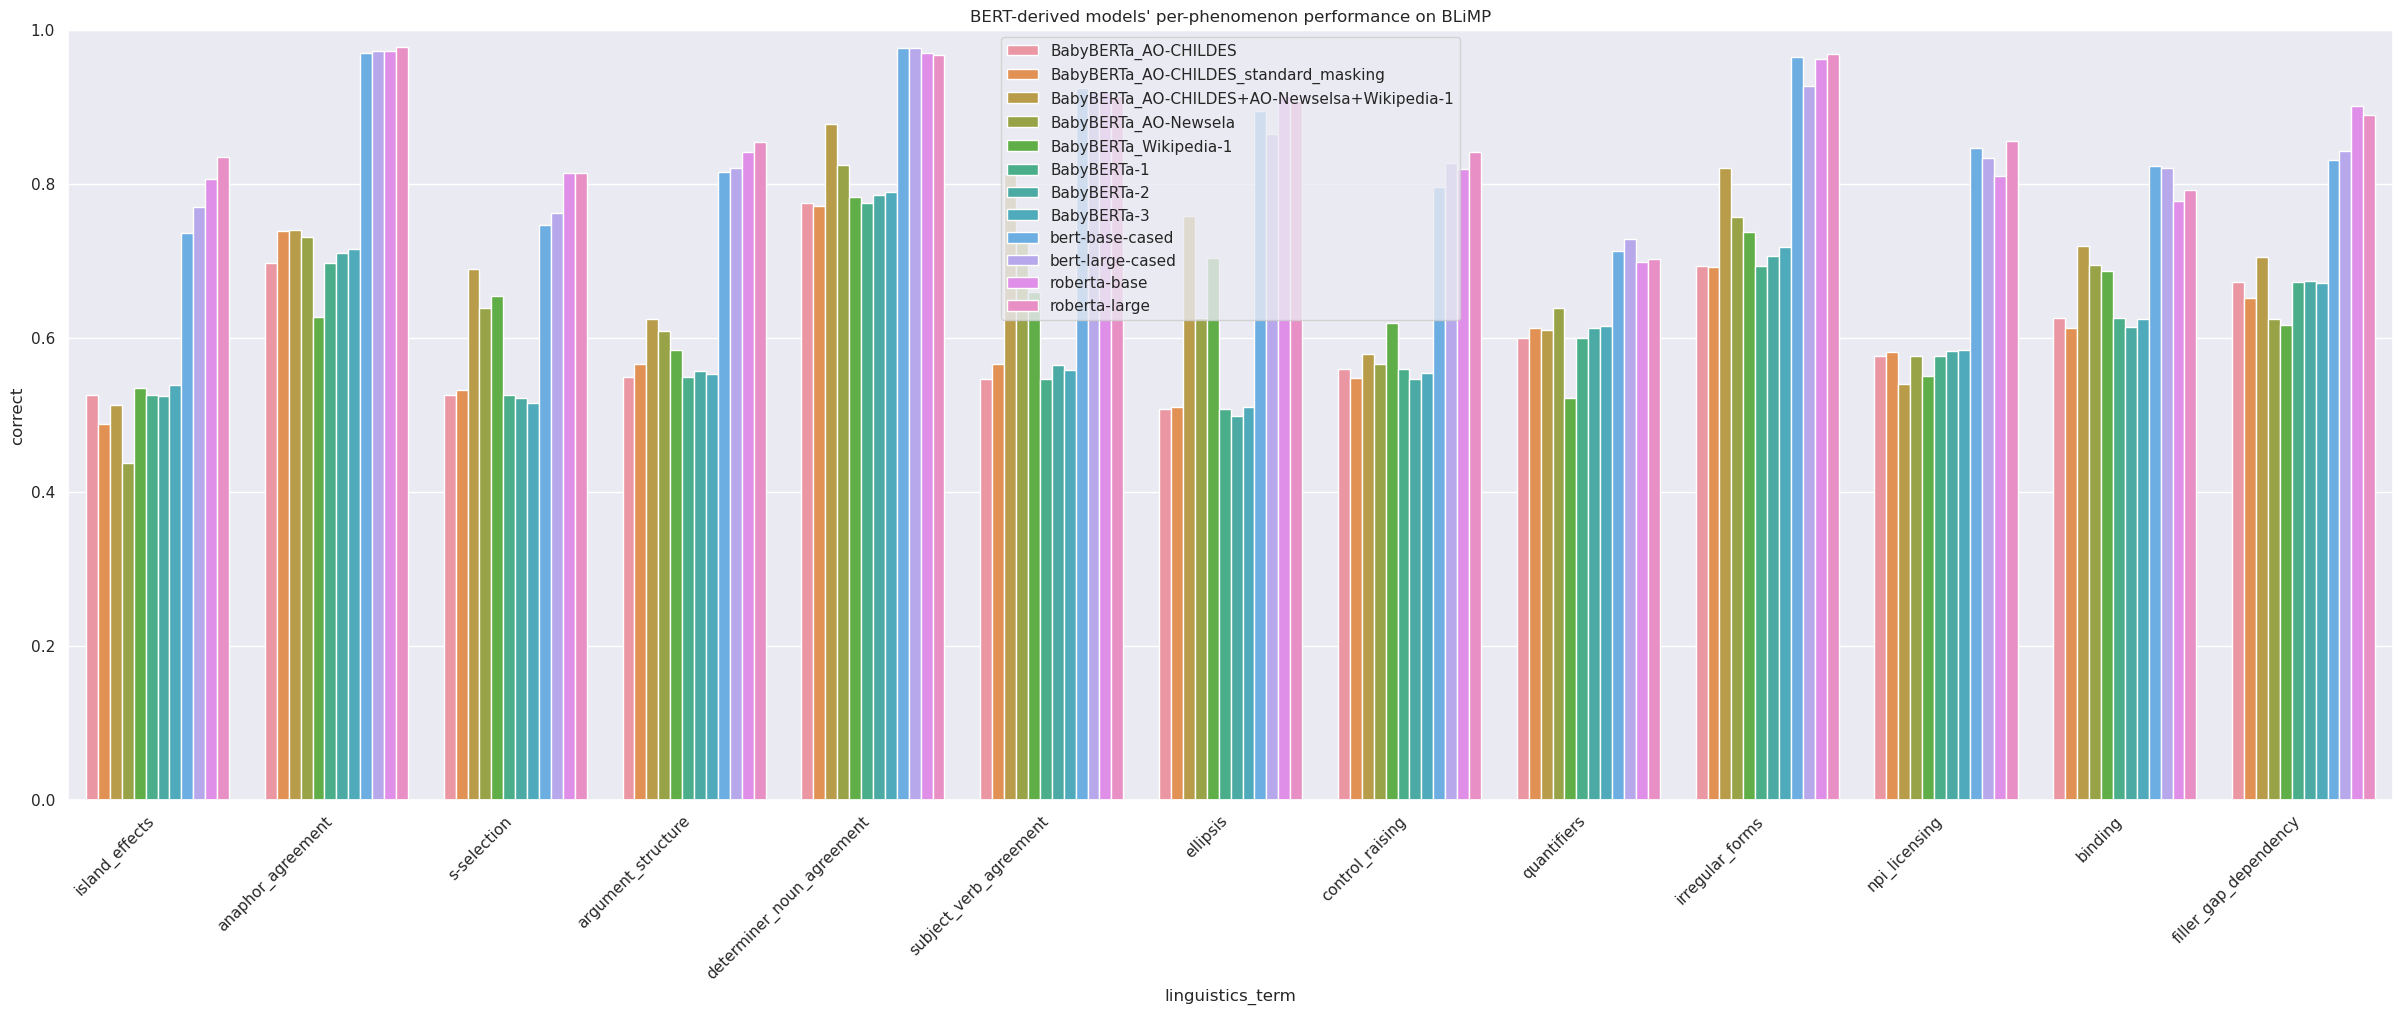

In [217]:
## How did the BERT models do on BLiMP?
all_models_blimp["correct"] = (all_models_blimp.pseudoLogProb_good > all_models_blimp.pseudoLogProb_bad).astype(int)
for model in all_models_blimp.model.unique():
    subset = all_models_blimp.loc[all_models_blimp.model == model]
    print(f"Overall {model} performance on BLiMP:" +\
          f"{subset.correct.sum()}/{subset.size} ({np.mean(subset.correct)}) \n")

# Plot.
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(all_models_blimp, x="linguistics_term", y="correct", hue="model", errorbar=None, ax=ax)
#ax.bar_label(ax.containers[-1], fmt='Mean:\n%.2f', label_type='edge') # Label the bars.
# Include overall average performance.
#ax.axhline(y=babyberta_blimp_avg_perf, label='BabyBERTA-1 mean BLiMP perf.', linestyle='--');

# Styling and labeling.
ax.set_ylim([0.0, 1.0])
plt.xticks(rotation=45, ha='right');
ax.legend();
ax.set_title("BERT-derived models' per-phenomenon performance on BLiMP")

plt.show()

Overall phueb/BabyBERTa-1 performance on Zorro:29884/460000 (0.6496521739130435) 

Overall phueb/BabyBERTa-2 performance on Zorro:30415/460000 (0.6611956521739131) 

Overall phueb/BabyBERTa-3 performance on Zorro:29603/460000 (0.6435434782608696) 

Overall bert-base-cased performance on Zorro:42706/460000 (0.9283913043478261) 

Overall bert-large-cased performance on Zorro:42667/460000 (0.9275434782608696) 

Overall roberta-base performance on Zorro:41500/460000 (0.9021739130434783) 

Overall roberta-large performance on Zorro:41223/460000 (0.8961521739130435) 



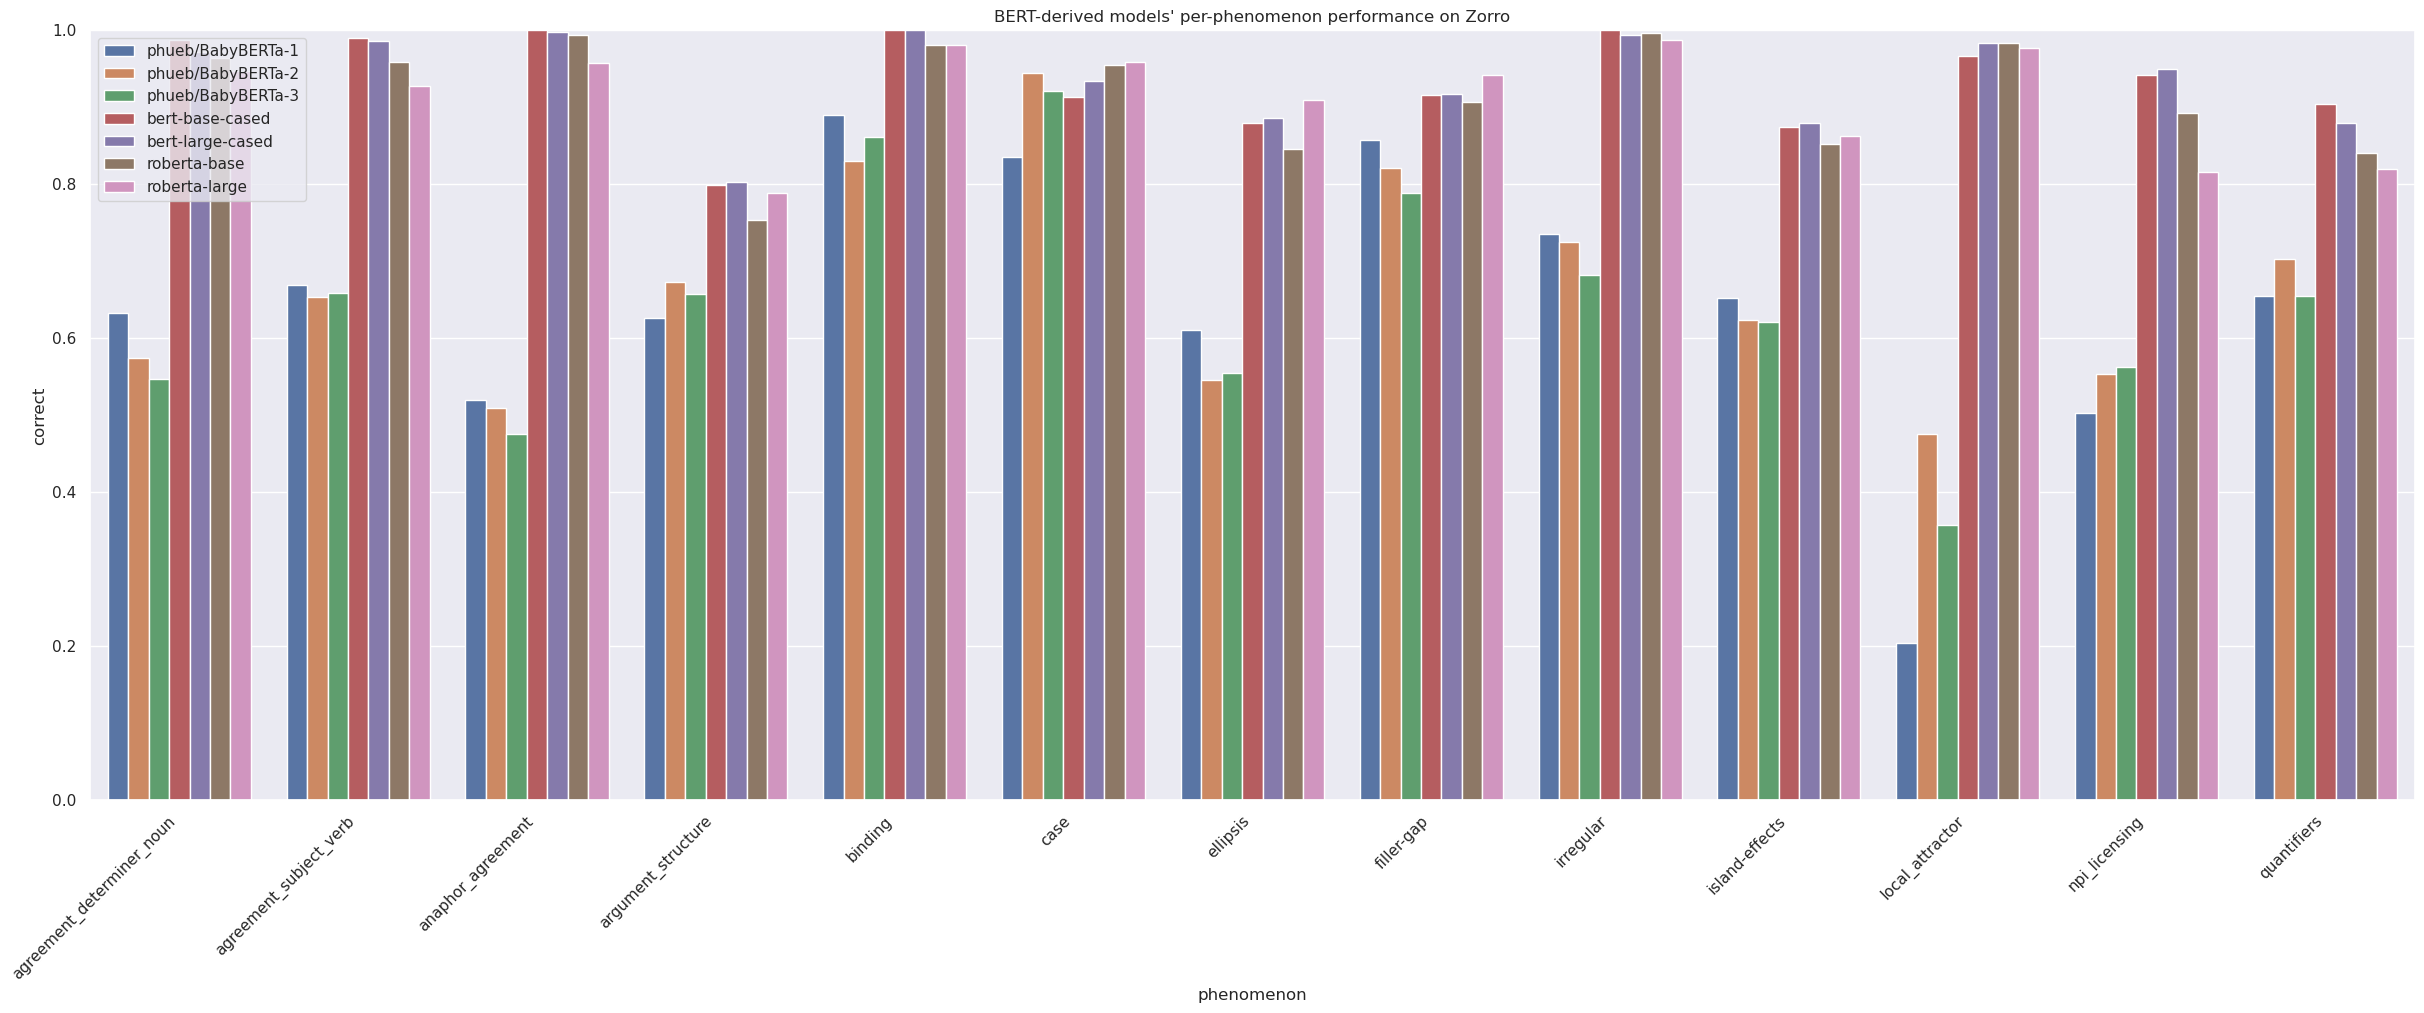

In [218]:
## How did the BERT models do on BLiMP?
all_models_zorro["correct"] = (all_models_zorro.pseudoLogProb_good > all_models_zorro.pseudoLogProb_bad).astype(int)
for model in all_models_zorro.model.unique():
    subset = all_models_zorro.loc[all_models_zorro.model == model]
    print(f"Overall {model} performance on Zorro:" +\
          f"{subset.correct.sum()}/{subset.size} ({np.mean(subset.correct)}) \n")

# Plot.
fig, ax = plt.subplots(figsize=(30, 10))
sns.barplot(all_models_zorro, x="phenomenon", y="correct", hue="model", errorbar=None, ax=ax)
#ax.bar_label(ax.containers[-1], fmt='Mean:\n%.2f', label_type='edge') # Label the bars.
# Include overall average performance.
#ax.axhline(y=babyberta_blimp_avg_perf, label='BabyBERTA-1 mean BLiMP perf.', linestyle='--');

# Styling and labeling.
ax.set_ylim([0.0, 1.0])
plt.xticks(rotation=45, ha='right');
ax.legend();
ax.set_title("BERT-derived models' per-phenomenon performance on Zorro")

plt.show()

## Scrambling Experiment

In [27]:
# Helper function to assemble Zorro.
def assemble_zorro(zorro_directory):
    all_zorro_files = glob.glob(os.path.join(zorro_directory, "*.txt"))
    zorro = pd.DataFrame(columns=["sentence_good", "sentence_bad", "phenomenon", "paradigm"])
    for f in all_zorro_files:
        # Read file.
        # File structure is a list of sentences arranged in minimal pairs.
        frame = pd.read_csv(f, names=["sentence"])

        # Split the DataFrame into good and bad sentences.
        bad = frame.iloc[::2].reset_index(drop=True) # every other row, starting from the first one.
        good = frame.iloc[1::2].reset_index(drop=True) # every other row, starting from the 2nd one.

        # Merge them to mirror BLiMP.
        zorro_subset = good.merge(bad, 
                                  left_index=True,
                                  right_index=True,
                                  suffixes=("_good", "_bad"),
                                  validate="one_to_one"
                                 )

        # Clean up filename to annotate DataFrame.
        start = f.rfind('/') + 1 # to strip path info.
        end = -4                 # to eliminate .txt extension.
        annotation = f[start:end]

        # Split filename into phenomenon and paradigm.
        sep = annotation.rfind('-') # the last hyphen always separates phenomenon from paradigm.
        phenomenon = annotation[:sep]
        paradigm = annotation[sep+1:]

        # Annotate the DataFrame.
        zorro_subset["phenomenon"] = phenomenon
        zorro_subset["paradigm"] = paradigm

        # Add to full Zorro.
        zorro = pd.concat([zorro, zorro_subset], ignore_index=True)
    return zorro

In [47]:
# Run BabyBERTa models on scrambled Zorro data.
models_to_test = ['saved_models/BabyBERTa_AO-CHILDES',
                  'saved_models/BabyBERTa_AO-CHILDES_standard_masking',
                 ]

seed_count = 0 # For keeping track of the different scrambled Zorro runs.
for seed in os.listdir(ZORRO_SCRAMBLED):
    # Check that the path is not a hidden folder.
    if seed.startswith('.'): continue

    # load Scrambled Zorro.
    zorro_dir = os.path.join(ZORRO_SCRAMBLED, seed)
    zorro_scrambled = assemble_zorro(zorro_dir)

    # Tag this particular scrambled dataset.
    zorro_scrambled["scrambling_seed"] = seed_count
    seed_count +=1 # update the seed counter.
    
    # Run the simulation.
    babyberta_zorro = test_models(models_to_test, 
                                  zorro_scrambled, 
                                  output_dir=BABYBERTA_SCRAMBLED_ZORRO_OUT, 
                                  device=device)

Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBERTa_AO-CHILDES_standard_masking...
Now testing saved_models/BabyBERTa_AO-CHILDES...
Now testing saved_models/BabyBE

In [39]:
os.listdir(ZORRO_SCRAMBLED)

['.git', '.gitignore', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [40]:
os.isdir(ZORRO_SCRAMBLED + "0")

AttributeError: module 'os' has no attribute 'isdir'

In [45]:
os.path.join(os.path.join(ZORRO_SCRAMBLED, "0"), "*.txt")

'./data/Zorro_scrambled/0/*.txt'

In [ ]:
os.path.join(zorro_directory, "*.txt")